# Mangrove Analysis  

## Global Mangrove Watch Data
[Global Mangrove Watch (GMW)](https://www.globalmangrovewatch.org/) is an initiative to track global mangrove extents. It uses combined ALOS PALSAR and Landsat (optical) data to form a baseline shapefile for the year 2010. More detailed information on the initiative can be found [here](http://data.unep-wcmc.org/datasets/45). To summarize, GMW shapefiles provide a general location of all mangroves in the world.

The shapefile used by this notebook is a country specific extraction from the global shapefile provided by GMW. The purpose of this notebook is to use the extracted shapefile as a baseline for classifying mangroves through NDVI thresholding. We then analyze how the mangroves change over time in our area of interest.

---
## Analysis Process
The process begins with retrieving data for a specific area in a time series. This dataset is then compressed into a mean composite for each year. From the mean composite, we then calculate the NDVI values of each pixel in each year. The dataset is then masked, and the NDVI threshold is applied for mangrove classification. The following image shows the decision tree for the classification.

![Mangrove Decision Tree](../Supplementary_data/Mangroves_analysis/mangrove_decision_tree.png)


After classification, we can perform a variety of analyses on the data. We can estimate the change in mangrove areas by counting all the classified pixels for each year and plotting the trend line of the count. We can also visualize the mangrove areas by plotting each classified pixel a certain color. 

## Define Options Here
Areas and times of interest are included as examples.

## Imports

In [3]:
%matplotlib inline

import warnings, sys
from sys import path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import geopandas as gpd

import datacube
from datacube.utils import geometry
from odc.algo import to_f32, from_float, xr_geomedian, reshape_for_geomedian

warnings.filterwarnings("ignore")

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import display_map, rgb, map_shapefile
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_spatialtools import xr_rasterize
from deafrica_classificationtools import HiddenPrints

## Load the Data
This method loads the data from the Open Datacube using the defined options above.

## Features
The following methods will be the features we build for our classification.


### NDVI

NDVI is used for mangrove classification within the mangrove mask.


$$ NDVI = \frac{NIR - Red}{NIR + Red} $$



### NDWI

NDWI is used for creating a better greyscale image when displaying the results.


$$ NDWI = \frac{Green - NIR}{Green + NIR} $$

## Classification
The MangroveClassifier object is used for building features and classifying mangroves based on a given threshold.

---
# Results
The following section holds the results of running the code above.

## Loading the Data

In [4]:
# dataset = load_dc_data(PLATFORM, PRODUCT, LATITUDE, LONGITUDE, YEARS)
dc = datacube.Datacube(app='Mangrove')

create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:36449' processes=1 threads=2, memory=14.18 GB>

In [5]:
lat = -6.1367
lon = 39.1751

# lat = -4.1
# lon = 39.5

buffer = 0.1
product_name = 'ls8_usgs_sr_scene'
query = {
   #'y': (-6.2006, -6.1099), #, (lon-buffer, lon+buffer),
   #'x': (39.4090, 39.5213), #(lat+buffer, lat-buffer),
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15),
}

output_crs = mostcommon_crs(dc=dc, product=product_name, query=query)

In [6]:
vector_file = '../Supplementary_data/Mangroves_analysis/chwaka_mangrove.shp'
attribute_col = 'FID'
#read shapefile
gdf = gpd.read_file(vector_file)

In [7]:
import xarray as xr
import odc.algo
def calc_geomedian(ds, 
                   axis="time", 
                   max_value=None, 
                   min_value=None,
                   num_threads=1, 
                   eps=1e-7, 
                   nocheck=True):
    '''
    Runs geomedian over a xarray.Dataset or xarray.DataArray.
    
    Specify min_value and max_value if known for better performance, 
    especially if using dask.
    
    Parameters
    ----------
    da : xarray.DataArray object
    max_value : the maximum value that could be found in the array
    min_value : the minimum value that could be found in the array
    '''
    da = odc.algo.reshape_for_geomedian(ds, axis=axis) if isinstance(ds, xr.Dataset) else ds

    if max_value is None:
        max_value = da.max(skipna=True)
    if min_value is None:
        min_value = da.min(skipna=True)

    offset = min_value
    scale = max_value - min_value

    da_scaled = odc.algo.to_f32(da, scale=(1 / scale), offset=(-offset / scale))

    geomedian = odc.algo.xr_geomedian(da_scaled, num_threads=num_threads, eps=eps, nocheck=nocheck)

    geomedian = odc.algo.from_float(
        geomedian,
        dtype=da.dtype,
        nodata=np.nan,
        scale=scale,
        offset=offset,
    )

    if isinstance(ds, xr.Dataset):
        geomedian = geomedian.to_dataset(dim='band')

    return geomedian

In [8]:
map_shapefile(gdf, attribute=attribute_col)

Label(value='')

Map(center=[-6.1835555555553725, 39.46066666666621], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [9]:
geom = geometry.Geometry(gdf.unary_union, gdf.crs)

In [10]:
ds_dataset = load_ard(
    dc=dc, 
    products=[product_name],
    output_crs=output_crs,
    dask_chunks={'time': 1, 'x': 500, 'y': 500},
    geopolygon=geom,
    **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 231 time steps as a dask array


In [11]:
da = reshape_for_geomedian(ds_dataset)
da_annual_geomedian = da.groupby('time.year').map(calc_geomedian, max_value=10000, min_value=0)
annual_geomedian = da_annual_geomedian.to_dataset(dim='band')

In [12]:
ds_geomedian = calculate_indices(annual_geomedian, index=['NDVI', 'NDWI'], collection = 'c1')

In [13]:
ds_geomedian.load()

<xarray.Dataset>
Dimensions:          (x: 426, y: 291, year: 8)
Coordinates:
  * x                (x) float64 5.446e+05 5.446e+05 ... 5.573e+05 5.573e+05
  * y                (y) float64 -6.792e+05 -6.792e+05 ... -6.878e+05 -6.879e+05
  * year             (year) int64 2013 2014 2015 2016 2017 2018 2019 2020
Data variables:
    coastal_aerosol  (y, x, year) float32 176.00163 175.45224 ... 210.0
    blue             (y, x, year) float32 215.0009 217.7711 ... 426.05475 276.0
    green            (y, x, year) float32 577.999 551.9651 ... 698.09375 610.0
    red              (y, x, year) float32 346.00076 312.13336 ... 488.99997
    nir              (y, x, year) float32 3129.9932 3425.6978 ... 3234.9998
    swir1            (y, x, year) float32 1645.9979 1621.3011 ... 1833.9999
    swir2            (y, x, year) float32 695.0001 648.4801 ... 912.99994
    sr_aerosol       (y, x, year) float32 130.0035 125.51851 ... 159.99998
    radsat_qa        (y, x, year) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NDVI             (y, x, year) float32 0.8009198 0.8329869 ... 0.73737913
    NDWI             (y, x, year) float32 -0.6882415 -0.72246754 ... -0.68270487
Attributes:
    crs:           epsg:32637
    grid_mapping:  spatial_ref
    nodata:        nan

#### Masking out



Rasterizing to match xarray.DataArray dimensions (291, 426) and projection system/CRS (e.g. epsg:32637)


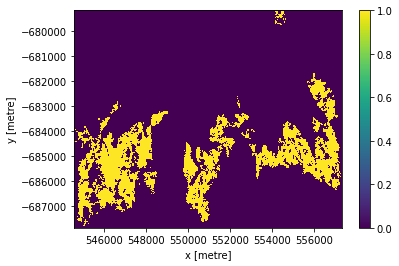

In [18]:
mask = xr_rasterize(gdf, ds_geomedian)
mask.plot();

In [17]:
# Mask dataset to set pixels outside the polygon to `NaN`
ds_dataset_masked = ds_geomedian.where(mask)

# Stack the orginal and masked data together to make plotting easier
ds_geomedian_both = xr.concat([ds_geomedian, ds_dataset_masked], pd.Index(['not masked', 'masked'], name='masked'))

We can plot the original NDVI of the region along with the identified mangrove area:

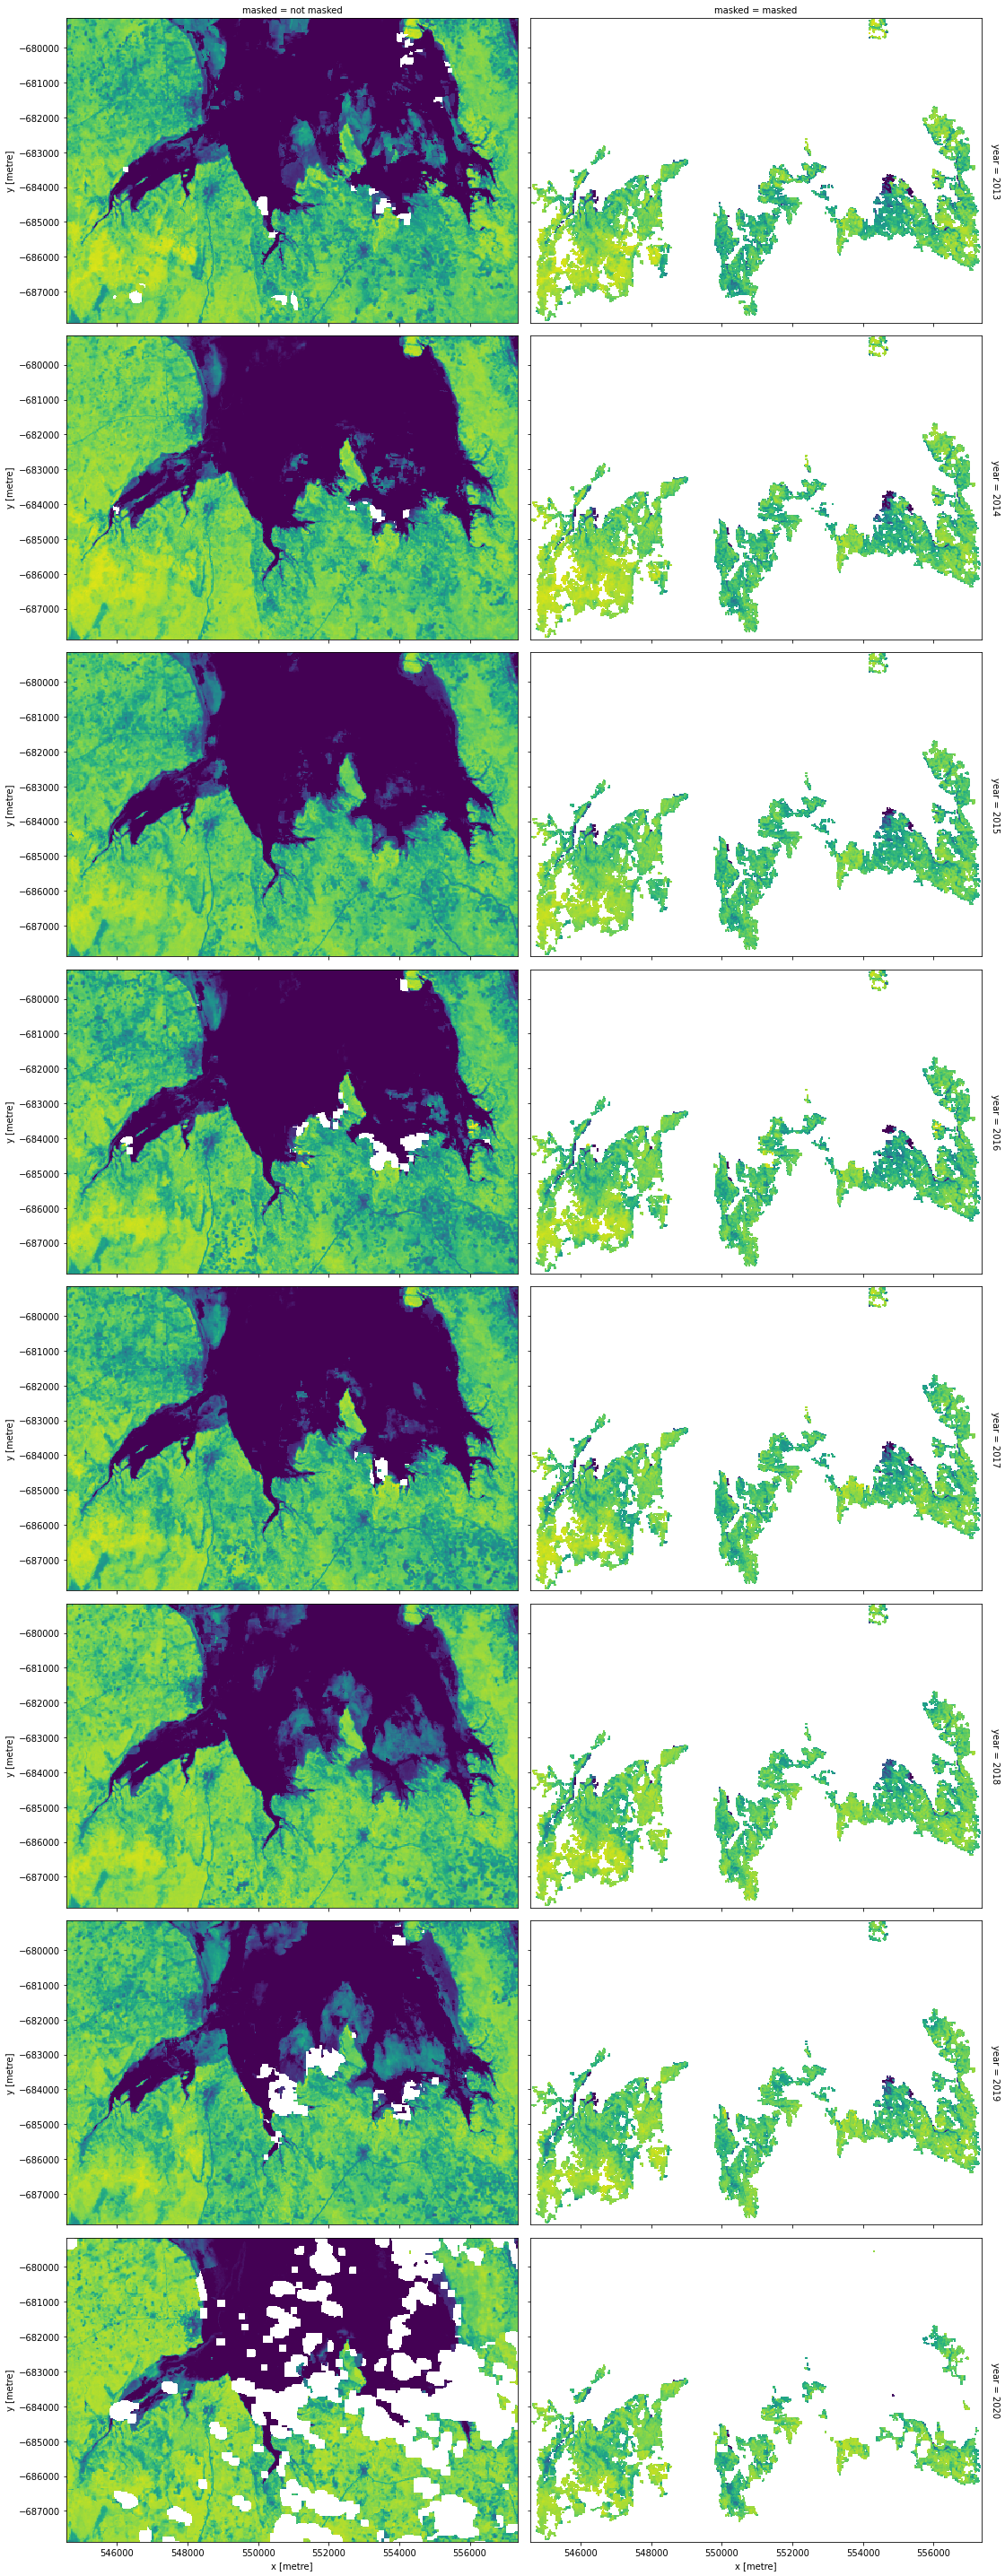

In [19]:
ds_geomedian_both.NDVI.plot(
    row='year', 
    col='masked',
    cmap='viridis',
    vmax=1,
    vmin=0,
    add_colorbar=False,
    size=5,
    aspect=ds_geomedian_both.x.size/ds_geomedian_both.y.size,
);

### Calculating Open and Closed Mangroves

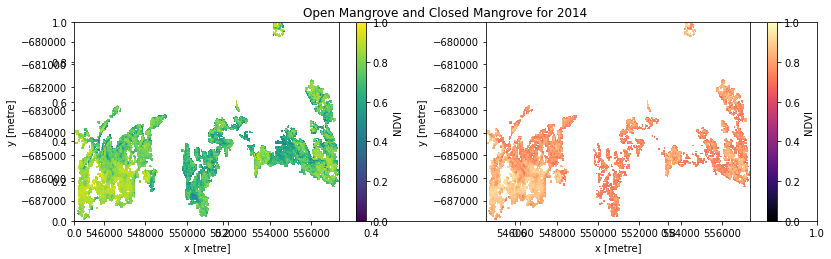

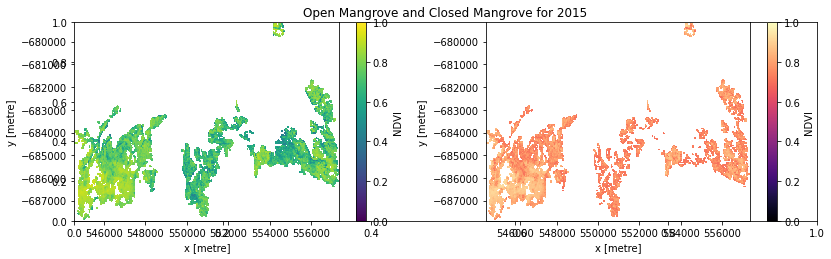

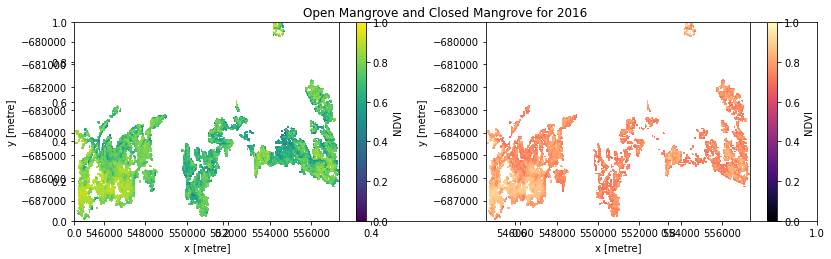

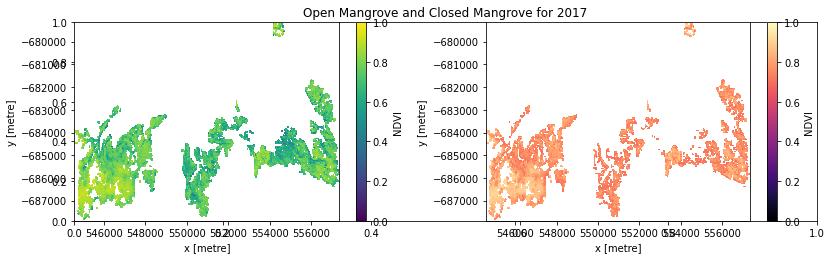

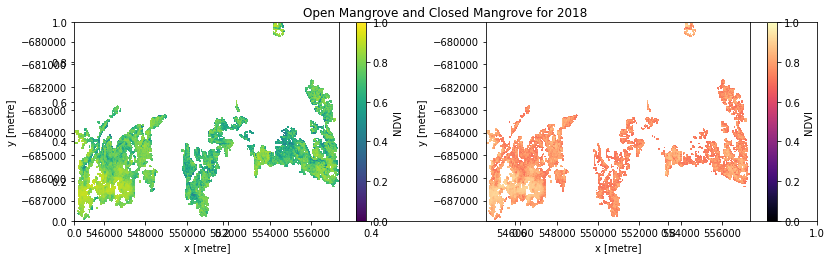

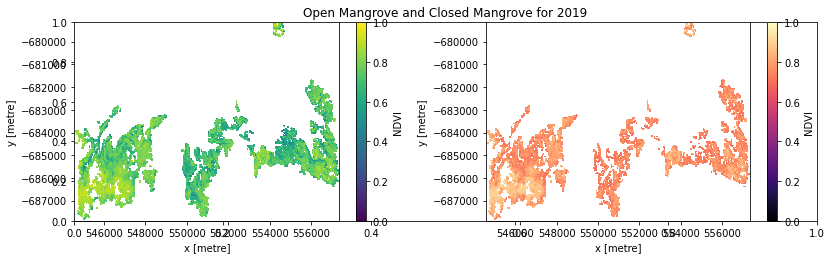

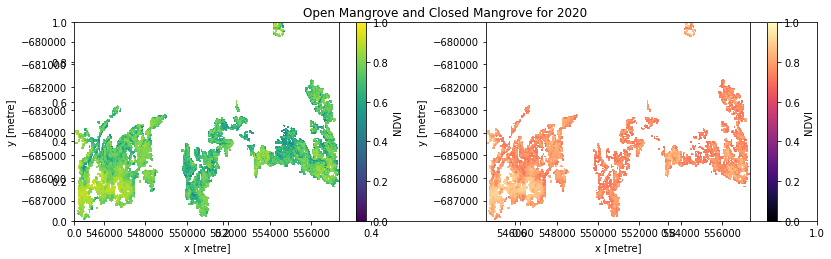

In [22]:
for images_year in images_years:
    fig = plt.figure(figsize=(12, 4))
    plt.title(f'Open Mangrove and Closed Mangrove for {str(images_year)}')
    fig.add_subplot(1,2,1)
    datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4).plot(vmin=0.0, vmax=1)
    fig.add_subplot(1,2,2)
    datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.7).plot(cmap='magma', vmin=0.0, vmax=1)
    fig.tight_layout()  

In [23]:
closed_mangrove = {}
open_mangrove = {}
for images_year in images_years:
    closed_mangrove[images_year] = (datacollection[images_year][1]['NDVI'] > 0.7).astype(int).values.sum()
    open_mangrove[images_year] = (datacollection[images_year][1]['NDVI'] > 0.4).astype(int).values.sum()

In [24]:
df = pd.DataFrame(open_mangrove, index=['All Mangrove Count']).append(pd.DataFrame(closed_mangrove,index=['Closed Mangrove Count']))
df

2014   2015   2016   2017   2018   2019   2020
All Mangrove Count     18000  18030  18035  18029  18047  18054  18054
Closed Mangrove Count  12902  12675  12702  12821  13073  13208  13236

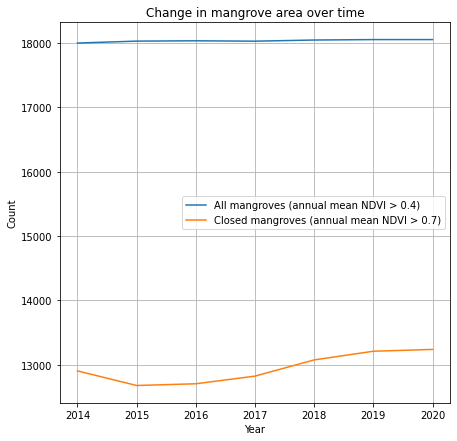

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(images_years, list(open_mangrove.values()), label='All mangroves (annual mean NDVI > {})'.format(0.4))
ax.plot(images_years, list(closed_mangrove.values()), label='Closed mangroves (annual mean NDVI > 0.7)')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Change in mangrove area over time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid()
plt.legend()

plt.show()

## Change in Mangroves
The following plot shows the change in pixel counts that correspond to a mangrove classification by means of the NDVI threshold.

## Mangroves Mapped
### All Mangroves for Chosen Year
The following image shows all the detected mangroves for the chosen year. Default selection is the last year in the selected range of years (YEARS[-1]).

Text(0.5, 1.0, 'Open Mangroves in 2020')

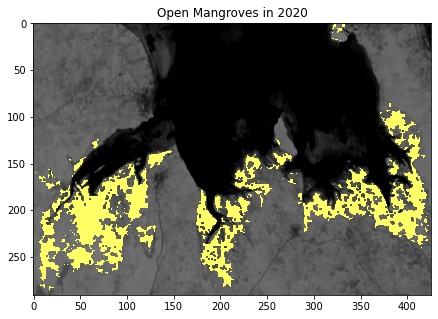

In [26]:
current_year = images_years[-1]
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[images_year][0]['NDVI'], cmap='gist_gray', vmin=0,vmax=2)
plt.imshow(datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4), cmap='summer',  vmin=0,vmax=0.5)
plt.title('Open Mangroves in ' + str(current_year))

### Closed Mangroves for Chosen Year
The following image is the same as the first, but highlights closed mangroves (with NDVI > 0.7).

* Green - Closed Mangroves
* OrRd - Other Mangroves

Text(0.5, 1.0, 'Closed Mangroves in 2020')

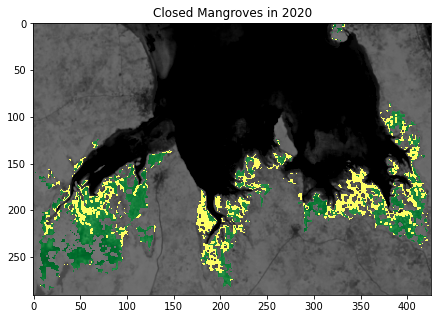

In [27]:
#Closed Mangroves
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[images_year][0]['NDVI'], cmap='gist_gray', vmin=0,vmax=2)
plt.imshow(datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4), cmap='summer',  vmin=0,vmax=0.5)
plt.imshow(datacollection[current_year][1]['NDVI'].where(datacollection[current_year][1]['NDVI'] > 0.7), cmap='Greens',  vmin=0,vmax=1)
plt.title('Closed Mangroves in ' + str(current_year))

### Change in Mangroves
The following image shows the change in mangroves between two selected years. Default selection is the oldest year and the year chosen above (YEARS[0], YEAR).

* Green - New Mangroves
* White - No Change
* Red - Loss of Mangroves

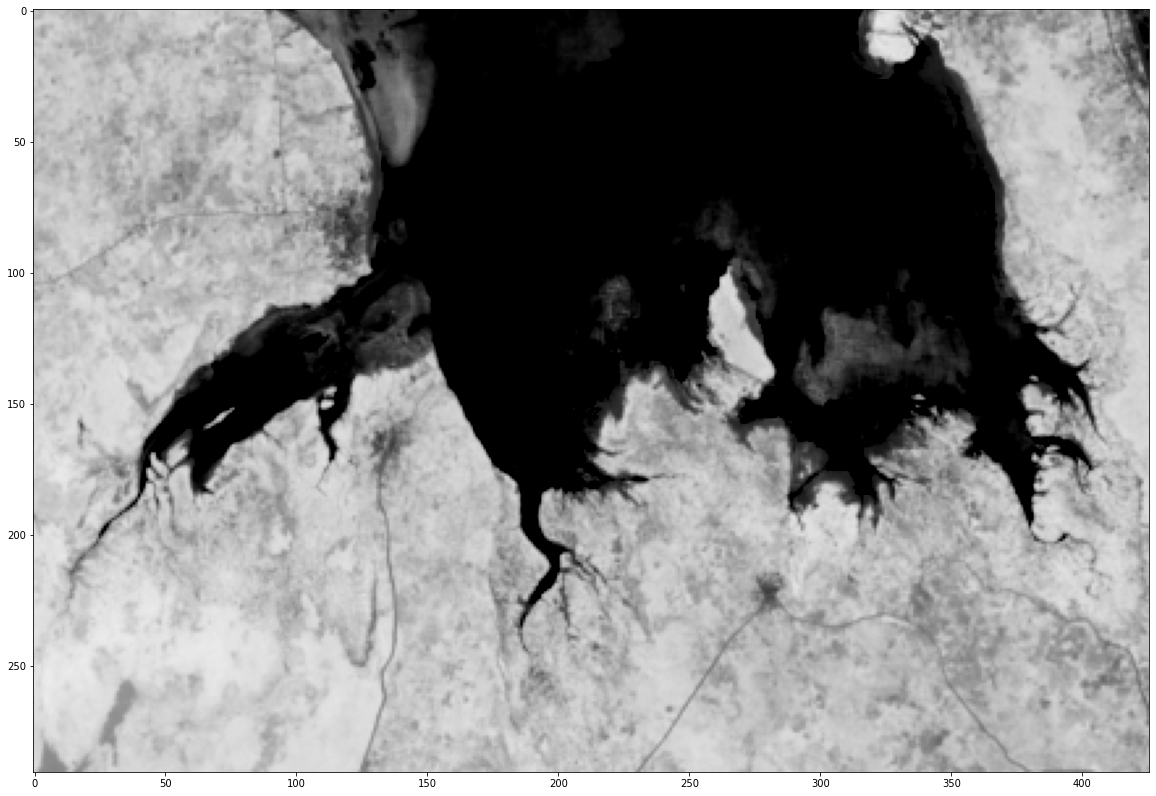

In [28]:
# # Select the year range here (ex: TIME = (2010, 2016)).
TIME = (images_years[0], current_year)

old_mangrove =  (datacollection[TIME[0]][1]['NDVI'] > 0.4).astype(int)
new_mangrove =  (datacollection[TIME[1]][1]['NDVI'] > 0.4).astype(int)

change = new_mangrove - old_mangrove
change_appeared = change.where(change==1)
change_disappeared = change.where(change==-1)
stable = change.where(change==0)

plt.figure(figsize=(20, 50),)



plt.imshow(datacollection[TIME[1]][0]['NDVI'],  cmap='gist_gray', vmin=0,vmax=1)
plt.imshow(change_appeared, cmap='Greens', vmin=0,vmax=1)
plt.imshow(change_disappeared, cmap='OrRd', vmin=-2,vmax=-1)


#### Pixel Counts

In [29]:
loss_count = (change==-1).values.sum()
gain_count = (change==1).values.sum()
stable_count = (change==0).values.sum()

counts = {
          'Loss of Mangroves': int(loss_count),
          'New Mangroves': int(gain_count),
#           'No Change': int(stable_count),
          'Delta Change': int(gain_count - loss_count)
          }

df = pd.DataFrame(counts, index=['Pixel Count'])
print('Pixel Counts of Mangrove Changes Between the Years {} and {}:'.format(TIME[0], TIME[1]))
df

Pixel Counts of Mangrove Changes Between the Years 2014 and 2020:


Loss of Mangroves  New Mangroves  Delta Change
Pixel Count                 15             69            54

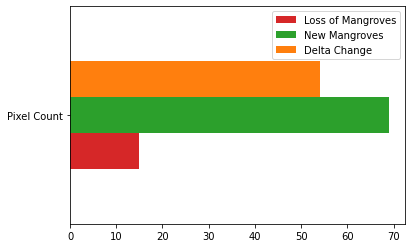

In [30]:
df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])